In [1]:
import copy
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
import PIPPET
import utils
from povelessen_cscores import cscores

In [3]:
#%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.style.use('default')
  
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.autolayout'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
sns.set_context('paper', font_scale=0.9)

# Stimuli (Henry, Herman & Grahn, 2017)

https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0172454&type=printable

"Simple rhythms were created by combining individual 4-unit measures, each of which contained between one and four intervals, as in [61]. The possible interval patterns in a measure were: 1-1-1-1, 1-1-2, 2-1-1, 1-2-1, 2–2, 1–3, 3–1, and 4. Measures occurred with probabilities estimated from [61]. Simple rhythms comprised 4 measures. Individual measures with interval structures 1–3 and 1-2-1 never occurred in the first two measures of the simple rhythm and no neighboring measures had the same interval structure... (simple: C = 0 ± 2)"

In [4]:
patterns = [[1,1,1,1], [1,1,2], [2,1,1], [1,2,1], [2,2], [1,3], [3,1], [4]]
patterns_i = np.arange(len(patterns))
not_first_two_measures = {patterns.index([1,2,1]), patterns.index([1,3])}

In [5]:
measures = 4
rhythms = []
for rs in itertools.product(patterns_i, repeat=4):
    consec = np.any((np.roll(rs, 1) == np.roll(rs, 0)) | (np.roll(rs, -1) == np.roll(rs, 0)))
    if consec or set(rs[:2]) & not_first_two_measures:
        continue
    rhythms.append(sum((patterns[i] for i in rs), []))

“'Rotated' versions of each simple rhythm were created by shifting the starting position of the rhythm to a different tone. The new starting position for each rhythm was chosen to maximize counterevidence scores for the rotated versions of the rhythms [6]; original: C = 1 ± 1; rotated: C = 12 ± 1, median ± IQR; Wilcoxon sign-rank test: W = 120, p < .001, re = .76), and thus likely minimize perceived beat strength."

In [6]:
def _cscores4(iois):
    for period, loc, divisible_period, C in cscores(iois, 4):
        if period != 4:
            continue
        assert divisible_period
        yield period, loc, C

In [7]:
rhythm_cscores = []

for rhythm in rhythms:
    # Extract the best/worst C-score for 4-period rotations of each rhythm
    best_C, worst_C = np.inf, -np.inf
    best, worst = None, None
    for period, loc, C in _cscores4(rhythm):
        if loc == 1 and C <= best_C:
            best_C = C
            best = loc
        if loc != 1 and C >= worst_C:
            worst_C = C
            worst = loc
    rhythm_cscores.append((best_C, worst_C, best, worst))
    
rhythm_cscores = np.array(rhythm_cscores)

Sample some similar rhythms:

In [8]:
N = 20
simple_rhythms = []
rotated_rhythms = []

# Filter C scores of original/rotation by Henry et al.'s value range
suitable = np.where((rhythm_cscores[:, 0] == 1) & (rhythm_cscores[:, 1] == 12))[0]
np.random.shuffle(suitable)

simple_rhythms = []
rotated_rhythms = []
for i in suitable[:N]:
    scores = rhythm_cscores[i]
    loc = scores[-1]
    rotated = np.roll(rhythms[i], -(loc-1))
    simple_rhythms.append(rhythms[i])
    rotated_rhythms.append(rotated)
    #print(rhythms[i], '-{}->'.format(loc), rotated, '({})'.format(scores[1]))

## Participant Data (Henry, Herman & Grahn, 2017)

In [9]:
'''
Columns:
1. Trial number
2. Rhythm item number 
3. Rhythm type (1=simple, 2=simple rotated, 3=Nozaradan 2012, 4=Nozaradan 2012 rotated)
4. Starting position of rotated rhythm (0 if not rotated, see col. 3)
5. C-score of rotated rhythm (Povel & Essens model)
6. Beat-strength rating
'''
participant_mats = [scipy.io.loadmat(matfile) for matfile in glob.glob('/Users/thomaskaplan/Downloads/dryad_data/exp2b_data/*.mat')]

# Simulations

In [10]:
#bs = lambda m: np.exp(-m.V_s/2).mean()
bs = lambda m: (m.V_s**-1).mean()

In [11]:
p = PIPPET.PIPPETParams()
p.dt = 0.005
p.overtime = p.dt
p.tmax = 2*np.pi * 4
p.lambda_0 = 0.001
p.sigma_phi = 0.2
p.mu_0 = 0
p.V_0 = 0.1
p.eta_mu = 0.00
p.eta_e = 0.00
p.eta_V = 0.00
e_means = np.array([0.0,])
e_vars = np.array([0.01,])
e_lams = np.array([0.01,])

def _run(rs):
    p_ = copy.deepcopy(p)
    e_ts = 2*np.pi * (np.cumsum(rs) - rs)/4
    p_.add(e_ts, e_means, e_vars, e_lams, '')
    m = PIPPET.cPIPPET(p_)
    m.run()
    return m

In [12]:
simple_models, rotated_models = [], []
for i, (s_rs, r_rs) in enumerate(zip(simple_rhythms, rotated_rhythms)):
    simple_models.append(_run(s_rs))
    rotated_models.append(_run(r_rs))

In [13]:
bs_simple = [bs(m) for m in simple_models]
bs_rotated = [bs(m) for m in rotated_models]
bs_simple_mean, bs_rotated_mean = np.mean(bs_simple), np.mean(bs_rotated)

In [14]:
# Henry et al reported: (t(17) = 3.80, p = .001, re = .66, Fig 5)
ttest = ttest_ind(bs_simple, bs_rotated, equal_var=False)
ttest

Ttest_indResult(statistic=6.208200889989772, pvalue=4.55068455726529e-06)

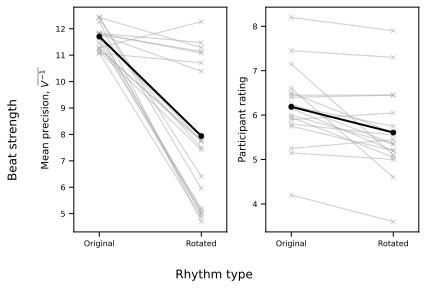

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=True)
          
for s, r in zip(bs_simple, bs_rotated):
    axs[0].plot([0, 1], [s, r], marker='x', c='darkgray', alpha=0.5)
axs[0].plot([0, 1], [bs_simple_mean, bs_rotated_mean], marker='o', lw=2, c='black')


axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Original', 'Rotated'])
axs[0].set_xlim([-0.25, 1.25])
#axs[0].set_ylim([None, 1.0])
axs[0].set_ylabel(r'Mean precision, $\widebar{V^{-1}}$', fontsize=10, labelpad=5)
#axs[0].set_xlabel('Rhythm type', fontsize=11)

# Extract Henry et al. (2017) data
ss, rr = [], []
for mat in participant_mats:
    mat = mat['data'].copy()
    # Ensure that there are no duplicate ids across stimulus types
    mat[mat[:, 2] > 2, 1] += 20
    s, r = [], []
    for i in set(mat[:, 1]):
        pair = mat[mat[:, 1] == i]
        # Orig/rotated ids differ by stimulus type
        orig_id = 1 if i < 20 else 3
        orig = pair[pair[:, 2] == orig_id]
        rot = pair[pair[:, 2] != orig_id]
        # Ensure a pair of stimuli per ID
        assert orig.shape == rot.shape == (1, 6)
        s.append(orig[0, -1])
        r.append(rot[0, -1])
    ss.append(s)
    rr.append(r)
    axs[1].plot([0, 1], [np.mean(s), np.mean(r)], marker='x', c='darkgray', alpha=0.5)
    
axs[1].plot([0, 1], [np.mean(ss), np.mean(rr)], marker='o', lw=2, c='black')

axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Original', 'Rotated'])
axs[1].set_xlim([-0.25, 1.25])
axs[1].set_ylabel('Participant rating', fontsize=10, labelpad=5)


fig.supxlabel('Rhythm type', fontsize=12)
fig.supylabel('Beat strength', fontsize=12)

#axs[1].set_xlabel('Rhythm type', fontsize=11)

plt.subplots_adjust(wspace=0.3, left=0.175, bottom=0.15)

fig.tight_layout()
fig.savefig('figures/fig_beatstrength.pdf', bbox_inches='tight')